# Neural Network

Import libraries

In [41]:
import itertools
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import unique_labels
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import datetime
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap



Bring in data

In [2]:
# read in sparse representation of vocabulary
sparse_matrix = scipy.sparse.load_npz('../Data/subreddit_csr_5000.npz')

# read in vocabulary itself
with open('../Data/subreddit_vocabulary_5000.json', 'r') as file:
    vocabulary = np.array(json.load(file))

# read in class labels
with open('../Data/subreddit_classes.json', 'r') as file:
    classes = np.array(json.load(file))


In [3]:
print(f'Sparse Matrix: {sparse_matrix.shape}')
print(f'Vocabulary: {vocabulary.shape}')
print(f'Classes: {classes.shape}')

Sparse Matrix: (200000, 5000)
Vocabulary: (5000,)
Classes: (200000,)


## Cleaning and EDA

In [4]:
# see vocab
np.unique(vocabulary)



array(['aa', 'aaron', 'aatrox', ..., 'zombi', 'zone', 'zyra'],
      dtype='<U15')

In [5]:
# see unique classes 
np.unique(classes)


array(['AskReddit', 'leagueoflegends', 'relationships', 'tifu', 'trees'],
      dtype='<U15')

In [6]:
# replace 'tifu' for 'timu'
classes = np.char.replace(classes, 'tifu', 'timu')
np.unique(classes)


array(['AskReddit', 'leagueoflegends', 'relationships', 'timu', 'trees'],
      dtype='<U15')

In [7]:
# visualize sparse matrix
if True == False: # set to true to see the matrix in table form
    dense_matrix = sparse_matrix.todense()
    dense_matrix = pd.DataFrame(dense_matrix)
    display(dense_matrix)

## Preprocess

In [8]:
# subset the data if needed
use_full_data = True # set to true to use full data
rows_to_subset = 100000

if use_full_data == False:
    idx = np.random.choice(sparse_matrix.shape[0], size=rows_to_subset, replace=False) # to make sure same rows get sampled from both
    X_sparse_matrix = sparse_matrix[idx,:]
    y_data = classes[idx]
elif use_full_data == True:
    X_sparse_matrix = sparse_matrix
    y_data = classes
else:
    raise ValueError("Choose true of false in 'use_full_data'")

# see shapes
print(f'X Sparse Matrix: {X_sparse_matrix.shape}')
print(f'Y Data: {y_data.shape}')


X Sparse Matrix: (200000, 5000)
Y Data: (200000,)


In [9]:
# see load balance
pd.Series(y_data).value_counts()

AskReddit          40000
leagueoflegends    40000
relationships      40000
timu               40000
trees              40000
dtype: int64

In [10]:
# create x and y
X = X_sparse_matrix.toarray()
y = y_data

# encode y into numbers
encoder = LabelEncoder()
y = encoder.fit_transform(y)


## Model

In [11]:
class SparseDataset(Dataset):
    """
        __init__ creates tensors from x and y
        __len__ gets the len of X
        __get_ item allows for retrieving specific rows of data from both X and y
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class Classifier(nn.Module):
    """
    __init__:
        3 fully connected layers
        input layer is the size of the countvectorized vector of words
        second hidden layer is half the first one
        output layer is equal to the number of classes in the dataset
        relu is the activation function
        dropout randomly sets a fraction of inputs to 0 to help with overfitting issues
        
    forward:
        how the dataset goes through the network
    """
    
    def __init__(self, input_size, hidden_size, num_classes, dropout_rate=0.5):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2) # second layer is half the first one
        self.layer3 = nn.Linear(hidden_size // 2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.layer3(x)
        return x


In [12]:
# calc params
input_layer_size = X.shape[1]
number_of_classes = len(np.unique(y_data))

# init vars and lists
best_test_accuracy = 0
best_first_hidden_size = None
best_learning_rate = None
best_dropout_rate = None
best_l1_reg_lambda = None
train_accuracies = []
test_accuracies = []
best_gs_params = None # for grid search
best_avg_test_accuracy = 0
epochs_without_improvement = 0
best_val_loss = float('inf')
weighted_precisions = []
weighted_recalls = []



In [13]:
# manual params
first_hidden_sizes = [128]
learning_rates = [0.001]
dropout_rates = [0.5]
l1_reg_lambdas = [0.0001]
num_epochs = 10
k_fold_splits = 5
early_stopping_patience = 5
batch_size = 128

# init k fold object
strat_k_fold = StratifiedKFold(n_splits=k_fold_splits, shuffle=True, random_state=42)

# grid search loop
for first_hidden_size, learning_rate, dropout_rate, l1_reg_lambda in itertools.product(first_hidden_sizes, learning_rates, dropout_rates, l1_reg_lambdas):
    print(f'Current selection={first_hidden_size}, learning_rate={learning_rate}, dropout_rate={dropout_rate}, l1_lambda={l1_reg_lambda}')

    # init average accuracy tracker
    avg_test_accuracy = 0

    # begin k fold cross validation
    for fold, (train_index, test_index) in enumerate(strat_k_fold.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # set tensors
        train_dataset = SparseDataset(X_train, y_train)
        test_dataset = SparseDataset(X_test, y_test)

        # set loaders / batch functionality
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # init model
        model = Classifier(input_layer_size, first_hidden_size, number_of_classes, dropout_rate=dropout_rate)
        # init crossentroply loss
        criterion = nn.CrossEntropyLoss()
        
        # init adam optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # init lists for train and test accuracy
        train_accuracies = []
        test_accuracies = []

        # train current fold
        for epoch in range(num_epochs):
            
            model.train()
            training_correct_predictions_count = 0
            training_samples_count = 0
            
            # init train batch
            for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_loader)):
                
                # forward pass
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                # L1 reg
                l1_norm = sum(p.abs().sum() for p in model.parameters()) # absolute value of model params
                loss += l1_reg_lambda * l1_norm # multiple times its lambda and add to loss

                # backward pass
                optimizer.zero_grad() # reset gradients
                loss.backward() # new gradients using backpropagation
                optimizer.step() # use gradients for gradient descent

                # compute performance
                _, predicted = torch.max(outputs.data, 1) # get predictions
                training_samples_count += y_batch.size(0)
                training_correct_predictions_count += (predicted == y_batch).sum().item()

            train_accuracy = training_correct_predictions_count / training_samples_count
            train_accuracies.append(train_accuracy)

            # evaluate on test set
            model.eval()
            testing_correct_predictions_count = 0
            testing_samples_count = 0
            val_loss = 0

            with torch.no_grad(): # doesn't count for backprop
                
                y_true_all = []
                y_score_all = []
                    
                for X_batch, y_batch in test_loader: # test loader now
                    
                    
                    # same as above
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)

                    # L1 regularization
                    l1_norm = sum(p.abs().sum() for p in model.parameters())
                    loss += l1_reg_lambda * l1_norm

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    testing_samples_count += y_batch.size(0)
                    testing_correct_predictions_count += (predicted == y_batch).sum().item()
                    
                    y_true_all.extend(y_batch.tolist())
                    y_score_all.extend(outputs.softmax(dim=1).tolist())
                    
                
            test_accuracy = testing_correct_predictions_count / testing_samples_count
            test_accuracies.append(test_accuracy)
            
            # get precision, recall
            y_true = np.array(y_true_all)
            y_score = np.array(y_score_all)
            y_pred = np.argmax(y_score, axis=1)

            weighted_precision, weighted_recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
            weighted_precisions.append(weighted_precision)
            weighted_recalls.append(weighted_recall)

            y_true = np.array(y_true_all)
            y_score = np.array(y_score_all)
            roc_auc = roc_auc_score(y_true, y_score, multi_class='ovr')

        # accumulate test accuracy
        avg_test_accuracy += test_accuracy
        
        # print
        print(f'Fold {fold + 1} completed')

    # calc avg test accuracy
    avg_test_accuracy /= k_fold_splits
    
    # precision, recall, roc
    avg_weighted_precision = np.mean(weighted_precisions)
    avg_weighted_recall = np.mean(weighted_recalls)

    print(f'Average test accuracy: {avg_test_accuracy:.4f}')
    print(f'Average weighted precision: {avg_weighted_precision:.4f}')
    print(f'Average weighted recall: {avg_weighted_recall:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')

    # update the best parameters if the average test accuracy is higher
    if avg_test_accuracy > best_avg_test_accuracy:
        best_avg_test_accuracy = avg_test_accuracy
        best_gs_params = {'hidden_size': first_hidden_size, 'learning_rate': learning_rate, 'dropout_rate': dropout_rate, 'l1_lambda': l1_reg_lambda}

# print
print(f'Best parameters: {best_gs_params}')
print(f'Best average test accuracy: {best_avg_test_accuracy:.4f}')
                    
                   

Current selection=128, learning_rate=0.001, dropout_rate=0.5, l1_lambda=0.0001


100%|██████████| 1250/1250 [00:05<00:00, 208.68it/s]


Fold 1 completed


100%|██████████| 1250/1250 [00:06<00:00, 190.22it/s]


Fold 2 completed


100%|██████████| 1250/1250 [00:06<00:00, 198.84it/s]


Fold 3 completed


100%|██████████| 1250/1250 [00:06<00:00, 190.06it/s]


Fold 4 completed


100%|██████████| 1250/1250 [00:06<00:00, 193.78it/s]


Fold 5 completed
Average test accuracy: 0.8457
Average weighted precision: 0.8465
Average weighted recall: 0.8435
ROC AUC: 0.9712
Best parameters: {'hidden_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.5, 'l1_lambda': 0.0001}
Best average test accuracy: 0.8457


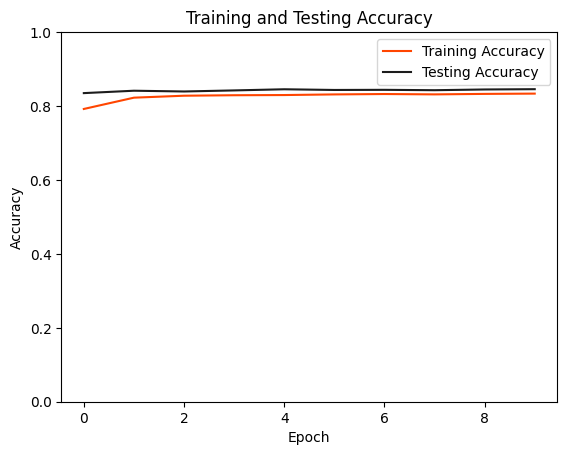

In [18]:
# plot training and testing accuracy
plt.plot(train_accuracies, label='Training Accuracy', color='#FF4500')
plt.plot(test_accuracies, label='Testing Accuracy', color='#1C1C1C')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.ylim(0, 1)
plt.show()



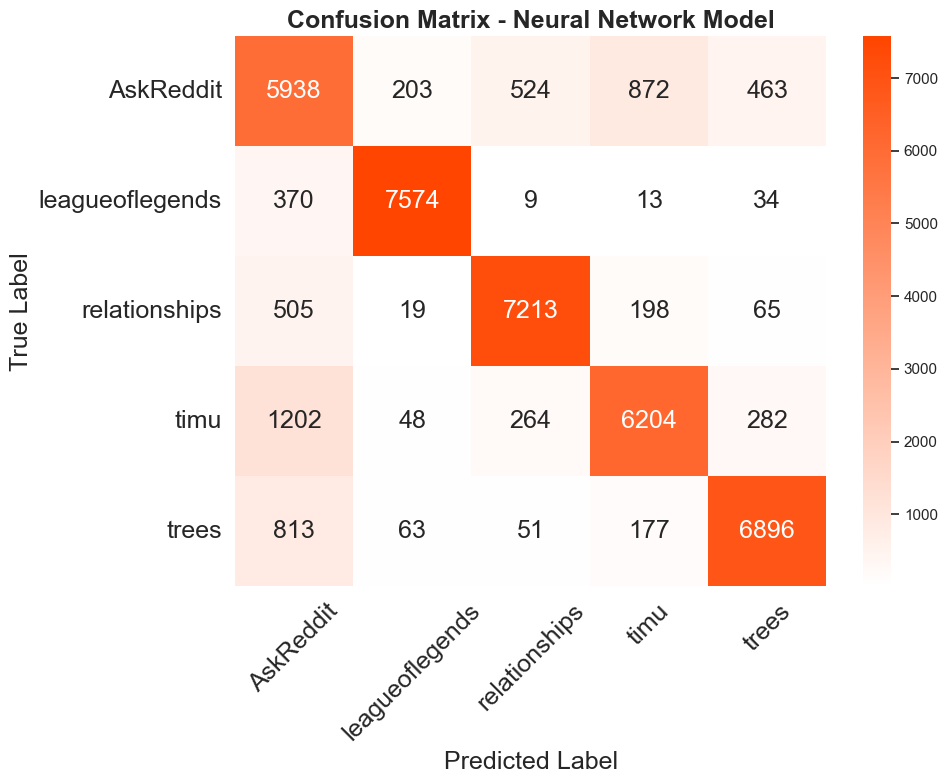

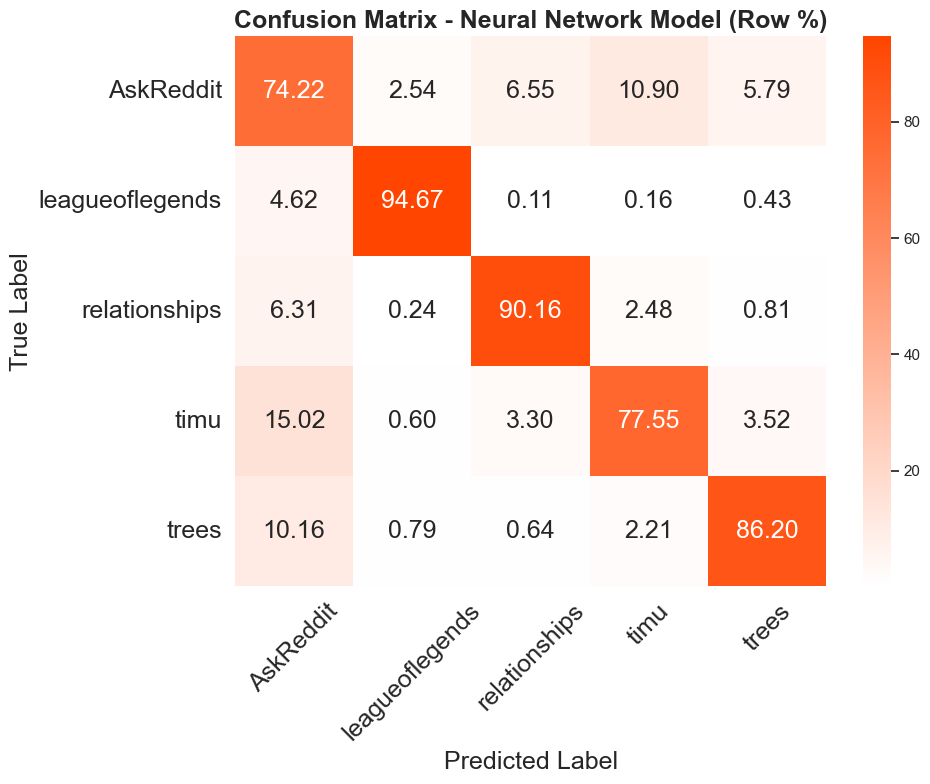

In [71]:
# matplotlib params
font_family_txt = 'Arial'
font_size_num = 18

#confusion matrix
def plot_confusion_matrix(y_true, y_pred, encoder, cmap=LinearSegmentedColormap.from_list('', ['#FFFFFF', '#FF4500']), row_percent= False):
    
    # formatiing
    fmt='d'
    plot_title_text = 'Confusion Matrix - Neural Network Model'
    savefile_name = 'nn_confusion_matrix'
    
    # turn the classes back into strings
    y_true_str = encoder.inverse_transform(y_true)
    y_pred_str = encoder.inverse_transform(y_pred)
    
    # init confucion matrix
    confusion_matrix_var = confusion_matrix(y_true_str, y_pred_str)
    unique_classes = unique_labels(y_true_str)
    
    if row_percent == True:
        confusion_matrix_var = confusion_matrix_var / confusion_matrix_var.sum(axis=1, keepdims=True) * 100
        fmt='.2f'
        plot_title_text = 'Confusion Matrix - Neural Network Model (Row %)'
        savefile_name = 'nn_confusion_matrix_pct'

    # init plot
    fig = plt.figure(figsize=(10, 8))

    sns.set()
    heatmap = sns.heatmap(confusion_matrix_var, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=unique_classes, yticklabels=unique_classes, annot_kws={"fontsize":font_size_num})
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 0)
    plt.title(plot_title_text, fontweight='bold', fontsize=font_size_num, fontfamily=font_family_txt)
    plt.xlabel('Predicted Label', fontsize=font_size_num, fontfamily=font_family_txt)
    plt.ylabel('True Label', fontsize=font_size_num, fontfamily=font_family_txt)
    heatmap.tick_params(axis='both', which='major', labelsize=font_size_num)
    plt.tight_layout()
    plt.savefig(f"../Output/NNResults/{savefile_name}.png")
    plt.show()

# get predictions for plot
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

# plot
plot_confusion_matrix(y_true, y_pred, encoder=encoder, row_percent= False)
plot_confusion_matrix(y_true, y_pred, encoder=encoder, row_percent= True)
